In [20]:
from notebook.services.config import ConfigManager
cm = ConfigManager()

cm.update('livereveal', {
              'width': "90%",
              'height': "90%",
              'scroll': True,
})

import warnings
warnings.filterwarnings('ignore')

bShowInline = True  # Set = False for document generation
%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
from ipywidgets import widgets, Layout, Box, GridspecLayout


##Basic mcq

def create_multipleChoice_widget(description, options, correct_answer, hint):
    if correct_answer not in options:
        options.append(correct_answer)
    
    correct_answer_index = options.index(correct_answer)
    
    radio_options = [(words, i) for i, words in enumerate(options)]
    alternativ = widgets.RadioButtons(
        options = radio_options,
        description = '',
        disabled = False,
        indent = False,
        align = 'center',
    )
    
    description_out = widgets.Output(layout=Layout(width='auto'))
    
    with description_out:
        print(description)
        
    feedback_out = widgets.Output()

    def check_selection(b):
        a = int(alternativ.value)
        if a==correct_answer_index:
            s = '\x1b[6;30;42m' + "correct" + '\x1b[0m' +"\n"
        else:
            s = '\x1b[5;30;41m' + "try again" + '\x1b[0m' +"\n"
        with feedback_out:
            feedback_out.clear_output()
            print(s)
        return
    
    check = widgets.Button(description="check")
    check.on_click(check_selection)
    
    hint_out = widgets.Output()
    
    def hint_selection(b):
        with hint_out:
            print(hint)
            
        with feedback_out:
            feedback_out.clear_output()
            print(hint)
    
    hintbutton = widgets.Button(description="hint")
    hintbutton.on_click(hint_selection)
    
    return widgets.VBox([description_out, 
                         alternativ, 
                         widgets.HBox([hintbutton, check]), feedback_out], 
                        layout=Layout(display='flex',
                                     flex_flow='column',
                                     align_items='stretch',
                                     width='auto')) 

test = create_multipleChoice_widget('1. Let a, b, c be real numbers. If a<b and b<c, then:',
                                   ['a>c','a<c','b<c','c<a'],
                                   'a<c',
                                   "[hint]:")

resolution = create_multipleChoice_widget('',
    ['A','B','C','D'],
    'D',"[hint]: what matters in the flight direction is the antenna length")



<img src="Figs/Banner.png" width="100%" />
<font face="Calibri">
<br>
<font size="6"> <b> Synthetic Aperture Radar Interferometry <b> </font>

<font size="4"> <b> SAR Principles and Phenomenology <font color='rgba(200,0,0,0.2)'> </font> </b> </font>

<br> <img src="Figs/NASALogo.png" width="250" align="right" /> <br> 
<font size="4"> <b> Paul A Rosen</b> 
<font size="3">  <br>
<font> <b>Date: </b> August 1, 2021 </font>
</font>


Contributors to content include: Scott Hensley, Anthony Freeman, Jakob van Zyl, Piyush Agram, Howard Zebker

This notebook presents the basics of synthetic aperture radar interferometry. The student will be exposed to:
    
1. What is Radar?
2. Basic definitions
3. What is Synthetic Aperture Radar?
4. Properties of Radar Images
5. What is Synthetic Aperture Radar Interferometry?
6. What other modalities of SAR are important?
7. What is range-Doppler geometry, why is it important, and how does it relate to geographic coordinates?



## Lecture Outline


### First Segment: Radar Imaging Fundamentals


1. <font color='green'>Basic Principles of Radar and SAR</font>
2. <font color='green'>Properties of Radar Images</font>


## Introduction and Motivation

You are reading this because you are interested in the geodetic aspects of synthetic aperture radar (SAR), particularly interferometric synthetic aperture radar (InSAR).  From a technical perspective, SAR and InSAR are quite complex, and even to experts in the field be a source of wonder as to how an instrument that illuminates a very large footprint on the ground can deliver almost arbitrarily fine resolution images, and relative motions of image points over time at mm to cm accuracy.  This can be illustrated by first looking at an "image" of the raw data before processing.





![label](Figs/Slide003.png)

![label](Figs/Slide004.png)

![label](Figs/Slide005.png)

![label](Figs/Slide006.png)

![label](Figs/Slide007.png)

![label](Figs/Slide008.png)

![label](Figs/Slide009.png)

![label](Figs/Slide010.png)

![label](Figs/Slide012.png)

![label](Figs/Slide013.png)

**Table of Radar and Spacecraft Parameters and constants used for any computed examples in this notebook**

| Parameter | Symbol | Value | Comment |
| --- | --- | --- | --- | 
| Wavelength | $\lambda $ | 0.24 m | (L-band)  
| Antenna Length | $L_a$ | 10 m | |  
| Antenna Width | $W_a$ | 2 m | |  
| Off-nadir boresight angle | $\theta_l$ | 30$^\circ$ | |
| Azimuth squint of  boresight angle | $\theta_{sq}$ | 0$^\circ$ | |
| Spacecraft Velocity | $v_{sc}$ | 7,500 m/s | Assumed constant |
| Spacecraft Altitude | $h_{sc}$ | 750,000 m | Assumed constant | 
| Radar Range Bandwidth | $B_r$ | 20 MHz | |
| Radar Pulse Duration | $\tau_r$ | 20 $\mu$s | Determines average power |
| Nominal Pulse Rate | $f_p$ | 1600 Hz | Determines average power and ambiguity levels |
| Peak Power on Transmit | $P_T$ | 4,000 W | Determines SNR |
| Radar Noise Temperature | $T_r$ | 300 K | Determines SNR |
| Corner Reflector Dimension | $L_{cr}$ | 2.4 m | Determines SNR |
| Speed of light         | $c $  | 299792456 m/s | |  
| Boltzman constant      | $k$   | 1.38064852 $\times$ 10$^{-23}$ m$^2$ kg s$^{-2}$ K$^{-1}$ | -228.6 dB |  
| Gravitational Constant | $G$   | 6.672 $\times$ 10$^{-11}$ m$^3$ kg$^{−1}$ s$^{−2}$ | |  
| Earth's Mass           | $M_E$ | 5.9742 $\times$ 10$^{24}$ kg | |

In [22]:
import numpy as np
Lambda = 0.24
L_a = 10.
W_a = 2. 
theta_l = 30. * np.pi/180.
theta_sq = 0. * np.pi/180.
v_sc = 7500.
h_sc = 750000. 
B_r = 20.e6
tau_r = 10.e-6
f_p = 1600.
P_T = 4000.
T_r = 300.
L_cr =2.4
c = 299792456 
k = 1.38064852e-23
G = 6.672e-11
M_E = 5.9742e24

![label](Figs/Slide018.png)

![label](Figs/Slide014.png)

## Range coding to achieve better resolution

If it is not possible to transmit a narrow enough pulse with sufficient power to achieve the desired results, it is customary to transmit a coded waveform in the pulse to create a broader bandwidth to the pulsed signal.  The resolution is then the reciprocal of the bandwidth. Specifically, the resolution of a radar pulse with no coded waveform of pulse duraftion $\tau_r$ is

\begin{equation}
\Delta\rho (\tau_r) = c *  \tau_r / 2
\end{equation}

while the resolution of a radar pulse with a waveform coded to have a bandwidth $B_r$  is

\begin{equation}
\Delta\rho (B_r)   = c * (1 /B_r) / 2
\end{equation}

In [23]:
rho = h_sc / np.cos(theta_l)
Delta_rho_taur = c *  tau_r / 2.
Delta_rho_Br   = c * (1./B_r) / 2.

In [24]:
print("Spacecraft altitude =","{:.2f}".format(h_sc),"m")
print("Pulse length =","{:.2f}".format(1.e6*tau_r),"microsec")
print("Pulse Bandwidth=","{:.2f}".format(1.e-6*B_r),"MegaHertz")
print("Range from spacecraft to boresight intersection with ground =","{:.2f}".format(rho),"m")
print("Range resolution based on pulse duration = ""{:.2f}".format(Delta_rho_taur),"m")
print("Range resolution based on bandwidth of coded range pulse = ""{:.2f}".format(Delta_rho_Br),"m")

Spacecraft altitude = 750000.00 m
Pulse length = 10.00 microsec
Pulse Bandwidth= 20.00 MegaHertz
Range from spacecraft to boresight intersection with ground = 866025.40 m
Range resolution based on pulse duration = 1498.96 m
Range resolution based on bandwidth of coded range pulse = 7.49 m


![label](Figs/Slide019.png)

## Ground Resolution Variability with Swath and Terrain

In [25]:
tau_p = 0.
theta=np.linspace(25.,45.,100)
Delta_rhog_Br = Delta_rho_Br / np.sin((theta-tau_p) * np.pi / 180.)
tau_p = 10.
Delta_rhog_Br_10deg = Delta_rho_Br / np.sin((theta-tau_p) * np.pi / 180.)
tau_p = 20.
Delta_rhog_Br_20deg = Delta_rho_Br / np.sin((theta-tau_p) * np.pi / 180.)

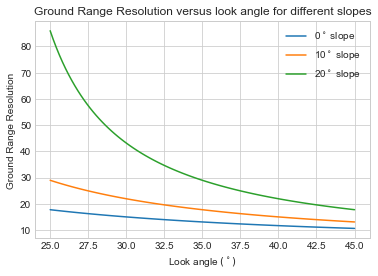

In [26]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
plt.plot(theta,Delta_rhog_Br,label='0$^\circ$ slope')
plt.plot(theta,Delta_rhog_Br_10deg,label='10$^\circ$ slope')
plt.plot(theta,Delta_rhog_Br_20deg,label='20$^\circ$ slope')
plt.xlabel("Look angle $(^\circ)$")
plt.ylabel("Ground Range Resolution ")
plt.title("Ground Range Resolution versus look angle for different slopes")
plt.legend(loc='best');

![label](Figs/Slide016.png)

## Some Example Beam Dimensions

In [27]:
theta_3db_az = 0.866 * Lambda / L_a  # 0.866 factor typically more representative of actual 3dB point
theta_3db_el = 0.866 * Lambda / W_a
Delta_X_az = rho * theta_3db_az
Delta_X_el = rho * theta_3db_el / np.cos(theta_l)

In [28]:
print("Antenna Length in azimuth (along track) =","{:.2f}".format(L_a),"m")
print("Antenna Width in elevation (perp to boresight and azimuth)=","{:.2f}".format(W_a),"m")
print("Azimuth beamwidth =","{:.2f}".format(180.*theta_3db_az/np.pi),"degrees")
print("Elevation beamwidth =","{:.2f}".format(180.*theta_3db_el/np.pi),"degrees")
print("Azimuth beam extent at reference range =","{:.2f}".format(Delta_X_az),"m")
print("Elevation beam extent at reference range =","{:.2f}".format(Delta_X_el),"m")

Antenna Length in azimuth (along track) = 10.00 m
Antenna Width in elevation (perp to boresight and azimuth)= 2.00 m
Azimuth beamwidth = 1.19 degrees
Elevation beamwidth = 5.95 degrees
Azimuth beam extent at reference range = 17999.47 m
Elevation beam extent at reference range = 103920.00 m


![label](Figs/Slide022.png)

In [29]:
%%html
<video width=960 controls autoplay>
    <source src="Figs/SAR.mp4" type="video/mp4"/>
</video>

![label](Figs/Slide029.png)

## Azimuth Resolution Example

The two-way propagation of the signal from spacecraft to ground and back again gives a factor of two greater Doppler bandwidth extent across the azimuth beam than one might expect.  Thus the synthetic aperture length can be thought of as twice the illuminated swath extent.

In [30]:
# allow for some playing with parameters locally. 

theta_3db_az = 0.866 * Lambda / L_a  # 0.866 factor typically more representative of actual 3dB point
Delta_X_az = rho * theta_3db_az
SynAp_az = 2. * Delta_X_az
theta_SynAp = 0.866 * Lambda / SynAp_az
delta_x_SynAp = rho * theta_SynAp



In [31]:
print("Azimuth antenna length =","{:.2f}".format(L_a),"m")
print("Azimuth beam extent at reference range illuminating a target =","{:.2f}".format(Delta_X_az),"m")
print("Synthetic aperture length (effective) =","{:.2f}".format(SynAp_az),"m")
print("Synthetic aperture effective beamwidth =","{:.3f}".format(1000.*180.*theta_SynAp/np.pi),"millidegrees")
print("Synthetic aperture resolution =","{:.3f}".format(delta_x_SynAp),"m")

Azimuth antenna length = 10.00 m
Azimuth beam extent at reference range illuminating a target = 17999.47 m
Synthetic aperture length (effective) = 35998.94 m
Synthetic aperture effective beamwidth = 0.331 millidegrees
Synthetic aperture resolution = 5.000 m


<div class="alert alert-warning">
<font size="5"> <b> Test your understanding - Radar Resolution <b> </font>
</div>

What is the intrinsic resolution of a strip map SAR image with 40 MHz range bandwidth and an antenna of dimension 2 m in elevation and 12 m in the flight direction?

A. 12 m in range and 12 m in flight direction

B. 1 m in range and 6 m in flight direction

C. 3 m in range and 1 m in flight direction

D. 3 m in range and 6 m in flight direction 

In [32]:
resolution

![label](Figs/Slide027.png)

![label](Figs/Slide028.png)

![label](Figs/Slide028a.png)

![label](Figs/Slide028b.png)

## Learning more about SAR 

We have developed a comprehensive notebook that covers Synthetic Aperture Radar Theory and Processing Methods in much greater detail.  

It is included in the set of course notebooks under the "notebooks/SAR Processor Tutorial" folder. This notebook 
- simulates radar echoes from point targets
- develops the radar equation and the signal-to-noise ratio of corner reflector targets
- develops the range and azimuth signals and processing methods analytically and computationally. 
- describes linear FM signals and range compression
- describes Doppler and synthetic aperture concepts, including range migration
- contrasts standard range doppler processing methods to time domain approaches


![label](Figs/Slide033.png)

![label](Figs/Slide034.png)

![label](Figs/Slide034a.png)

![label](Figs/Slide035.png)

![label](Figs/Slide036.png)

![label](Figs/Slide037.png)

![label](Figs/Slide038.png)

![label](Figs/Slide039.png)

![label](Figs/Slide040.png)

![label](Figs/Slide041.png)

![label](Figs/Slide042.png)

![label](Figs/Slide043.png)

![label](Figs/Slide044.png)